[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Pattern drafting algorithm



In [ ]:
!pip install bezier


In [ ]:
import numpy as np
import shapely
from shapely.geometry.collection import GeometryCollection
from shapely.geometry import LineString, Point, Polygon, MultiPoint
from shapely.ops import split
from shapely.affinity import translate,rotate

import matplotlib.pyplot as plt
getcoords = lambda x: np.squeeze(x.coords)

def angle(v1, v2):
    """
    angle between two vectors

    Params
    -------

    v1,v2: ndarray (2,)

    Returns
    --------

    angle in radian
    """

    cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos, -1.0, 1.0))

class Line(LineString):
    """
    wrapper of shapely.geometry.LineString to make chained geometric manipulations more readable
    """

    def __init__(self,*args):
        super().__init__(*args)
    def horiz_point(self):
        return Point(getcoords(self)[0])
    def vert_point(self):
        return Point(getcoords(self)[-1])
    def invert(self):
        return Line(np.flipud(getcoords(self)))
    def mirrorx(self):
        return Line(getcoords(self)*np.array([-1,1]))
    def mirrory(self):
        return Line(getcoords(self)*np.array([1,-1]))
    def append(self,pointxy,dxy=None):
        if pointxy=='h':
            pointxy = self.horiz_point()
        if pointxy=='v':
            pointxy = self.vert_point()
        if dxy is not None:
            pointxy = translate(pointxy,*dxy)
        return Line(np.vstack([getcoords(self),getcoords(pointxy)]))
    def translate(self,dxy):
        if isinstance(dxy, Point):
            dxy = getcoords(dxy)
        return translate(self,*dxy)
    def rotate(self,theta,origin):
        line = rotate(self,theta,origin=origin,use_radians=True)
        print(type(line))
        return Line.create(line)
    @ classmethod
    def create(self,line):
        return Line(getcoords(line))


# empirical cup pattern

## read body measurements

In [ ]:
import pandas as pd
measurements = pd.read_csv('measurements.csv',index_col='name')
measurements['mm'] = measurements['cm']*10
measurements

,cm,mm
name,,
full,84.0,840.0
over,73.0,730.0
under,67.0,670.0
height,11.0,110.0
spacing,1.6,16.0
WireWidth,12.0,120.0


## create ellipse

In [ ]:
WireWidth = measurements.loc['WireWidth']['mm']
quarter_wire_circumf = WireWidth*np.pi/4

ChestHeight = measurements.loc['height']['mm']
AvgBust = measurements.loc[['under','over']]['mm'].mean()
BustAmount = measurements.loc['full']['mm']-AvgBust
ChestDiff = measurements.loc['over']['mm']-AvgBust

Percent = WireWidth/(AvgBust/4)
Horizontal = BustAmount*Percent+WireWidth
Vertical = (BustAmount+ChestHeight)*Percent

apex = Point((0,0))
ellipse = apex.buffer(1).exterior
ellipse = shapely.affinity.scale(ellipse,xfact=Horizontal/2,yfact=Vertical/2)


### crop ellipse to the length of quarter wire circuference

152.58537668063167 94.24777960769379


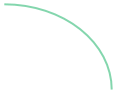

In [ ]:
minx, miny, maxx, maxy = ellipse.bounds
quarter = ellipse.intersection(Polygon([(maxx,0),(0,0),(0,maxy),(maxx,maxy)]))
print(quarter.length,quarter_wire_circumf)
quarter

In [ ]:

import bezier

def bezier_to_line(bcurve,seglength=5):
    L = bcurve.length
    N = max(20,int(L/seglength))
    s_vals = np.linspace(0, 1.0, N)
    xy = bcurve.evaluate_multi(s_vals).T
    return Line(xy)

def difference_to_target(curve,target,createcurve=True):
    if createcurve:
        curve = bezier.Curve.from_nodes(np.asfortranarray(np.array(curve).T))
    if target is None:
        return curve
    targetname,targetvalue = target
    if targetname=='distance':
        if isinstance(curve, bezier.curve.Curve):
            curve = bezier_to_line(curve)
        return np.sum([curve.distance(p) for p in targetvalue])# list of shapely.geometry.Point
    elif targetname=='length':
        return np.abs(curve.length-targetvalue)# number
    elif targetname=='z':
        s,z = targetvalue
        return np.abs(np.squeeze(curve.evaluate(s))[2]-z)# Parameter along the curve, z position


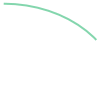

In [ ]:

def top_arc_length(splitY,quartercircle,minx,maxx,target,returnsplitted=False):
    splitline = LineString([(minx,splitY),(maxx,splitY)])
    splitted = split(quartercircle,splitline).geoms
    arc = splitted[0]
    if returnsplitted:
        return arc#[*splitted,splitline]
    return difference_to_target(arc,target,createcurve=False)

def crop_quartercircle(quarter,quarter_wire_circumf):
    minx, miny, maxx, maxy = quarter.bounds
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(
        top_arc_length, 
        method='bounded', bounds=[miny+1,maxy], 
        args=(quarter,minx,maxx,('length',quarter_wire_circumf))
        )
    arc = top_arc_length(res.x,quarter,minx,maxx,None,returnsplitted=True)
    return arc

cropped = crop_quartercircle(quarter,quarter_wire_circumf)
cropped

## create 4 `arc` corresponding to 4 quarter cup pieces

<class 'shapely.geometry.linestring.LineString'>


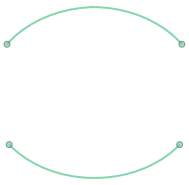

In [ ]:
arcs = {}
# arc at top right
temp = Line.create(cropped).invert()
p = translate(temp.vert_point(),-ChestDiff/8,0)
temp = temp.append(p)#correct for differences in chest circumference in between avgbust and overbust
theta = -angle(getcoords(p),[0,1])
temp = temp.rotate(theta,apex)
arcs['tr'] = temp

# arc at top left
arcs['tl'] = arcs['tr'].mirrorx()

# arc at bottom left and right
arcs['br'] = Line.create(cropped).invert().mirrory()
arcs['bl'] = arcs['br'].mirrorx()

from shapely.affinity import translate,rotate
GeometryCollection([GeometryCollection([arcs[name],arcs[name].horiz_point()]) for name in arcs.keys()])



## add seams 
|<img width=200/>|<img width=200/>|
|------------|--------------|
| v vertical | h horizontal |
| l left     | r right      |
| b bottom   | t top        |

length of horizontal seam is
     201.4 at top cup
     201.4 at bottom cup


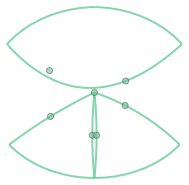

In [ ]:

def offsetpoint_perpendicular(startpoint,endpoint,theta,offset_position_percentage,offset_distance_percentage):
    from numpy.linalg import norm
    line = LineString([startpoint,endpoint])
    midpoint = line.interpolate(offset_position_percentage/100, normalized=True)
    unitvector = getcoords(endpoint)-getcoords(startpoint)
    unitvector /= norm(unitvector)
    offsetpoint = Point(getcoords(midpoint)+unitvector*offset_distance_percentage/100*line.length)# move midpoint towards endpoint on the line by offset_distance mm 
    offsetpoint = shapely.affinity.rotate(offsetpoint, theta, origin=midpoint, use_radians=False)
    return offsetpoint

def fitpoint(targetpoints,startpoint,endpoint,theta,control_position_percentage):
    wrapper = lambda distance: offsetpoint_perpendicular(startpoint,endpoint,theta,control_position_percentage,distance)
    getxy = lambda points: [getcoords(p) for p in points]
    func = lambda distance,target: difference_to_target(getxy([startpoint,wrapper(distance),endpoint]),target)

    from scipy.optimize import minimize_scalar
    res = minimize_scalar(
        func, 
        method='bounded', bounds=[0,100], 
        args=(['distance',targetpoints])
        )
    return bezier_to_line(func(res.x,None))

targetpoints = []
def bezierseam(startpoint,endpoint,theta,offset_position_percentage,offset_distance_percentage,control_position_percentage):
      target = offsetpoint_perpendicular(startpoint,endpoint,theta,offset_position_percentage,offset_distance_percentage)
      targetpoints.append(target)
      if control_position_percentage is None:
          return target
      else:
          return fitpoint([target],startpoint,endpoint,theta,control_position_percentage)

seams = {}
seams['vbr'] = bezierseam(apex,arcs['br'].vert_point(),theta=-90,
                          offset_position_percentage=50,offset_distance_percentage=2.5,control_position_percentage=50)
seams['vbl'] = bezierseam(apex,arcs['bl'].vert_point(),theta=90,
                          offset_position_percentage=50,offset_distance_percentage=2.5,control_position_percentage=50)
seams['hbr'] = bezierseam(apex,arcs['br'].horiz_point(),theta=90,
                          offset_position_percentage=33,offset_distance_percentage=5,control_position_percentage=50)
seams['hbl'] = bezierseam(apex,arcs['bl'].horiz_point(),theta=-90,
                          offset_position_percentage=50,offset_distance_percentage=2.5,control_position_percentage=50)
targets = [
           bezierseam(apex,arcs['tr'].horiz_point(),theta=-90,
                          offset_position_percentage=33,offset_distance_percentage=5,control_position_percentage=None),
           bezierseam(apex,arcs['tl'].horiz_point(),theta=90,
                          offset_position_percentage=50,offset_distance_percentage=2.5,control_position_percentage=None),
           apex,
]
seams['ht'] = fitpoint(targets,arcs['tl'].horiz_point(),arcs['tr'].horiz_point(),theta=-90,control_position_percentage=45)

print('length of horizontal seam is\n{:10.1f} at top cup\n{:10.1f} at bottom cup'.format(
    seams['ht'].length,seams['hbr'].length+seams['hbl'].length))
GeometryCollection(list(seams.values())+list(arcs.values())+targetpoints+[apex])

## group arcs and seams by cup piece

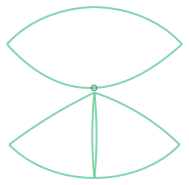

In [ ]:
patterns = {}
patterns['br'] = GeometryCollection([seams['vbr'],arcs['br'],seams['hbr']])
patterns['bl'] = GeometryCollection([seams['vbl'],arcs['bl'],seams['hbl']])
patterns['t'] = GeometryCollection([arcs['tl'],arcs['tr'],seams['ht'],seams['ht'].interpolate(seams['hbr'].length)])
GeometryCollection(list(patterns.values()))

# Frame pattern algorithm

## read the coordinates of the wire and scale the wire to millimeters

In [30]:
wirexy = pd.read_csv('wire.csv',index_col=0)
wirexy

,x,y
0,320.236667,-248.555651
1,320.221693,-248.687774
2,320.188208,-249.017097
3,320.142025,-249.534898
4,320.088960,-250.232454
...,...,...
111,440.706806,-274.996168
112,440.813799,-272.943482
113,440.871030,-270.846731
114,440.878595,-268.704653


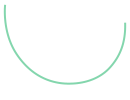

In [ ]:
wire = Line(wirexy.values)
wire

## front band pattern

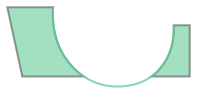

In [ ]:
offsety = 10
from shapely.ops import nearest_points
wirexy = getcoords(wire)
wire_left = Point(wirexy[0])
wire_right = Point(wirexy[-1])

bottomy = wirexy[:,1].min()+1
bottomx = split(wire,Line([(wire_right.x-10**3,bottomy),(wire_right.x+10**3,bottomy)])).geoms[1].centroid.x
cutline = Line([(bottomx,bottomy-20),(bottomx,bottomy+20)])
half_wire_left,half_wire_right = split(wire,cutline).geoms# split the wire at the bottom of the wire
wire_bottom = wire.intersection(cutline)

center_frontx = wire_right.x+measurements.loc['spacing']['mm']# center front x position

ffv = [# frame front vertices
    Point(center_frontx, wire_bottom.y+offsety),# frame_right_bottom
    Point(center_frontx, wire_right.y),# frame_right_top
    wire_right,# wire_right
    wire_left,# wire_left
    Point(center_frontx-measurements.loc['over']['mm']/4, wire_left.y),# frame_left_top
    Point(center_frontx-measurements.loc['under']['mm']/4, wire_bottom.y+offsety),# frame_left_bottom
]
frame_front = Polygon(ffv).difference(Polygon(wire))

GeometryCollection([
frame_front,wire,
])


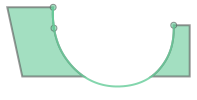

In [ ]:
# starting from the bottom of the wire, measure "quarter wire circufernece" upward and label the end point
quarter_wire_left = half_wire_left.interpolate(half_wire_left.length-quarter_wire_circumf)
quarter_wire_right = half_wire_right.interpolate(quarter_wire_circumf)

# in this example, only the left front band connects to the cup
quarter_wire_left_top,quarter_wire_left_bottom = split(wire,LineString([translate(quarter_wire_left,-10,0),translate(quarter_wire_left,10,0)])).geoms
quarter_wire_left_top = Line.create(quarter_wire_left_top)#correct for differences in chest circumference in between avgbust and overbust
patterns['bandfront'] = GeometryCollection([
    frame_front,
    GeometryCollection([quarter_wire_left,wire_left,quarter_wire_left_top]),
    GeometryCollection([quarter_wire_right,]),
])

GeometryCollection([
patterns['bandfront'],wire,
])


## back band pattern

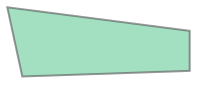

In [ ]:
backbandwidth = 40

centerback = Point(center_frontx, LineString(ffv[:2]).centroid.y)
patterns['bandback'] = Polygon([
    shapely.affinity.translate(centerback,yoff=-backbandwidth/2),
    shapely.affinity.translate(centerback,yoff=backbandwidth/2),
    *ffv[-2:],
    ])

patterns['bandback']

# Combine cup and frame pattern

## align top cup and bottom cup at where quarter wire circumference ends

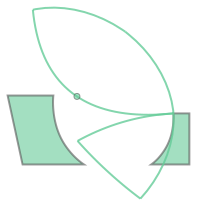

In [ ]:
StrapPositionOffCenter = (AvgBust/4-WireWidth)*(WireWidth/2)/(AvgBust/4)
StrapWidth = 20
# rotate the bottom cups to align the horizontal end of the arc to vertical postion
tangent = lambda arc,tangentidx: getcoords(arc)[tangentidx[1]]-getcoords(arc)[tangentidx[0]]

theta_top = {}
for name,direction,idxt,idxg in (['l',-1,[0,2],0],['r',1,[-1,-3],1],):
    bname = 'b'+name
    patterns[bname] = rotate(
        patterns[bname], 
        direction*angle(tangent(arcs[bname],[0,2]),
                        [0,-1]), 
        origin=arcs[bname].horiz_point(), 
        use_radians=True
        )
    
    tname = 't'+name
    theta_top[tname] = angle(tangent(seams['ht'],idxt),
          tangent(patterns[bname].geoms[-1],[-1,-3])
         )
    patterns[tname] = rotate(
        patterns['t'], 
        -1*direction*theta_top[tname], 
        origin=patterns['t'].centroid,
        use_radians=True
        )
    
    patterns[tname] = translate(
        patterns[tname],
        *(
          getcoords(Line.create(patterns[bname].geoms[1]).horiz_point())-
          getcoords(Line.create(patterns[tname].geoms[idxg]).horiz_point())
          )
    )

    patterns['f'+name] = translate(
        patterns['bandfront'],
        *(
          getcoords(Line.create(patterns[tname].geoms[idxg]).horiz_point())-
          getcoords(patterns['bandfront'].geoms[1+idxg].geoms[0])
          )
    )

patterns['tl'] = GeometryCollection([patterns['tl'],patterns['fl'].geoms[1],])

GeometryCollection([
patterns['fr'].geoms[0],patterns['br'],patterns['tr'],
])



## fill the gap between the wire and upper cup

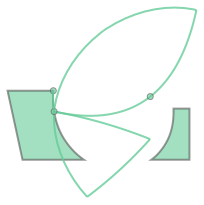

In [ ]:
GeometryCollection([
patterns['fl'].geoms[0],patterns['bl'],patterns['tl'],
])


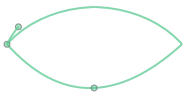

In [ ]:
patterns['tl'] = rotate(patterns['tl'],-theta_top['tl'],use_radians=True)
patterns['tl']

## label strap attachment position

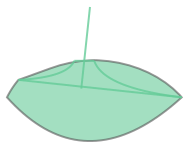

In [ ]:

from shapely.ops import linemerge

startpoint = patterns['tl'].geoms[1].geoms[1]
endpoint = Line.create(patterns['tl'].geoms[0].geoms[1]).horiz_point()
hline = Line([startpoint,endpoint])
vline = Line([offsetpoint_perpendicular(startpoint,endpoint,90,offset_position_percentage=50,offset_distance_percentage=0),
            offsetpoint_perpendicular(startpoint,endpoint,90,offset_position_percentage=50,offset_distance_percentage=50)])
vline = translate(vline,-StrapPositionOffCenter,0)
outline = Polygon(linemerge(list(patterns['tl'].geoms[0].geoms)[:-1])).convex_hull.union(patterns['tl'].geoms[1]).convex_hull
strappoint = outline.exterior.intersection(vline)
strapstart, strapend = translate(strappoint,-10,0),translate(strappoint,10,0)
strapleft = bezierseam(strapstart,startpoint,90,offset_position_percentage=20,offset_distance_percentage=10,control_position_percentage=20)
strapright = bezierseam(strapend,endpoint,-90,offset_position_percentage=20,offset_distance_percentage=10,control_position_percentage=20)

lst = [
outline,
strapleft,strapright,
vline,hline,
Line([strapstart, strapend])
]
GeometryCollection(lst)

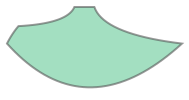

In [ ]:
from shapely.geometry import MultiLineString
from shapely.ops import unary_union

patterns['t'] = unary_union([
    split(outline,hline).geoms[0],
    Polygon(linemerge([hline,Line([strapstart, strapend]),strapleft,strapright]))
])
patterns['t']

# Unique to frameless bra

## separate left and right parts of the band

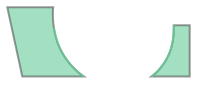

In [ ]:
cupbandseams = {
    'bl':split(quarter_wire_left_bottom,Line([ffv[0],ffv[-1]])).geoms[0],
    'br':split(half_wire_right,Line([ffv[0],ffv[-1]])).geoms[1],
}
GeometryCollection([
patterns['bandfront'].geoms[0],
*cupbandseams.values()
])

## mirror right band piece

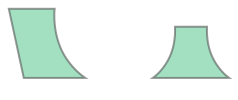

In [ ]:
def mirrorImage( P, Q, xys): 
    a = Q[1] - P[1]
    b = P[0] - Q[0]
    c = -(a*(P[0]) + b*(P[1]))
    mxys = np.zeros(xys.shape)
    for i,(x,y) in enumerate(xys):
        temp = -2 * (a * x + b * y + c) /(a * a + b * b)
        mxys[i] = (temp * a + x, temp * b + y) 
    return mxys

temp = translate(patterns['bandfront'], 0,-200)
frontbandcenter,frontbandside = temp.geoms[0].geoms
minx, miny, maxx, maxy = frontbandcenter.bounds
frontbandcenter_mirror = Polygon(mirrorImage((maxx,miny),(maxx,maxy),getcoords(frontbandcenter.exterior)))
frontbandcenter = frontbandcenter.union(frontbandcenter_mirror)

GeometryCollection([
frontbandside,
frontbandcenter
])

## all pattern pieces

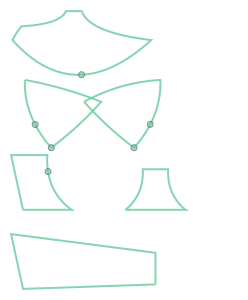

In [ ]:
finalpattern = {
    'cup top':            [patterns['t'].exterior,     patterns['tl'].geoms[0].geoms[-1]],
    'cup bottom left':    [linemerge(patterns['bl']),  patterns['bl'].geoms[1].interpolate(cupbandseams['bl'].length),   Line.create(patterns['bl'].geoms[1]).vert_point()],
    'cup bottom right':   [linemerge(patterns['br']),  patterns['br'].geoms[1].interpolate(cupbandseams['br'].length),   Line.create(patterns['br'].geoms[1]).vert_point()],
    'band center':        [frontbandcenter.exterior],
    'band side':          [frontbandside.exterior,   temp.geoms[1].geoms[0]],
    'band back':          [translate(patterns['bandback'].exterior, 0, -300)],
}

GeometryCollection([
    GeometryCollection(lst) for name,lst in finalpattern.items()
])


# Printable PDF patterns

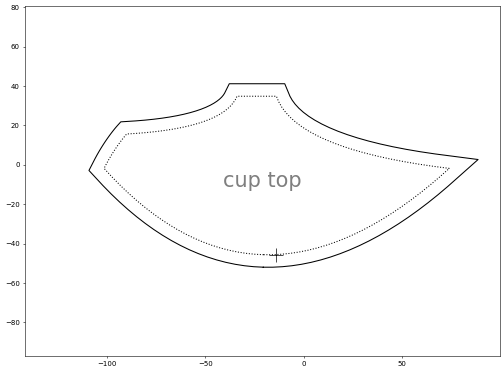

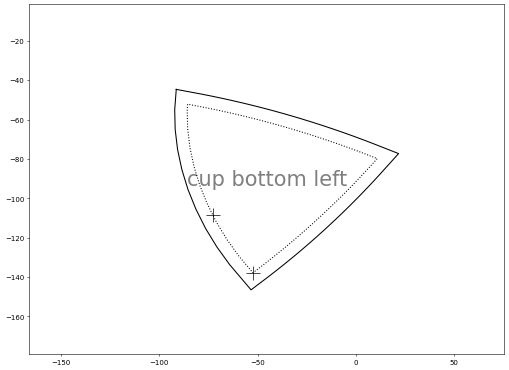

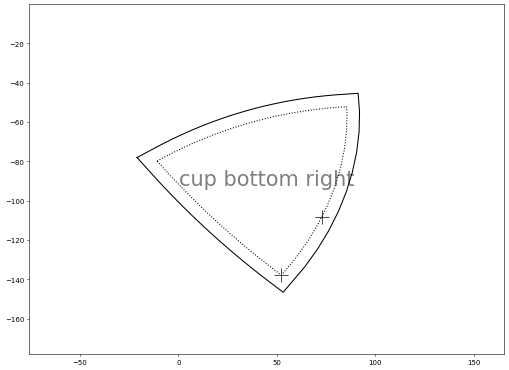

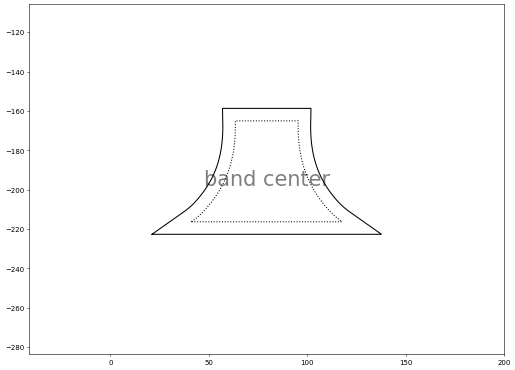

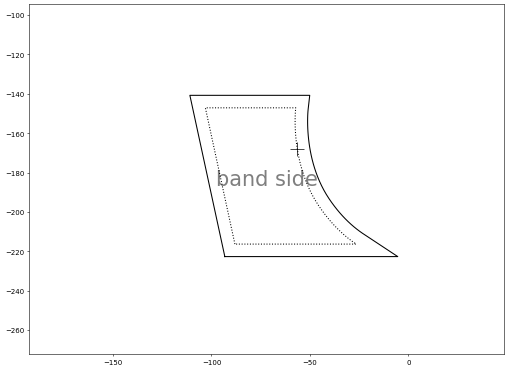

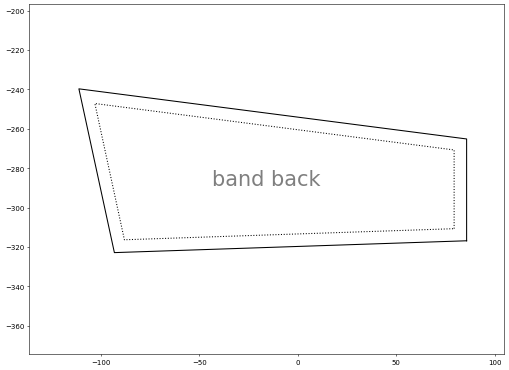

In [ ]:
def addax(fig,FW,FH,L,W,T,H, **kwargs):
    FW,FH = fig.get_figwidth(),fig.get_figheight()
    gridspec_kw={
    'left':L/FW, 'right':(L+W)/FW, 
    'top':1-T/FH,'bottom':1-(T+H)/FH}
    return fig.subplots(gridspec_kw=gridspec_kw, **kwargs)

def print_pattern(name, line, *args):# 1/4 inch seam_allowance
    w=266.7;h=203.2;mmtoinch=0.0393701;seam_allowance=6.35
    FW,FH = w*mmtoinch,h*mmtoinch
    fig = plt.figure(figsize=(FW,FH),dpi=50)
    
    W,H = w-1/mmtoinch,h-1/mmtoinch
    ax = addax(fig,FW,FH,0.5,W*mmtoinch,0.5,H*mmtoinch)


    from shapely.geometry import Polygon
    poly = Polygon(line)
    c = poly.centroid
    cx,cy = c.x,c.y
    ax.text(cx,cy,name, horizontalalignment='center',verticalalignment='center',fontsize=30,alpha=0.5)
    ax.set(aspect=1,
           xlim=[cx-W/2,cx+W/2],
           ylim=[cy-H/2,cy+H/2])

    ax.plot(*line.T,'k:')
    line2 = getcoords(poly.buffer(seam_allowance, join_style=2).exterior)
    ax.plot(*line2.T,'k')
    if args is not None:
        for arg in args:
            ax.plot(*arg,'k+',ms=20)

    #fig.savefig(label+'.pdf', transparent=True, rasterized=True)#
    return fig


figs = [print_pattern(name,*[getcoords(l) for l in lst]) for name,lst in finalpattern.items()]
filename = 'example'
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(filename+'.pdf') as pdf:
    for fig in figs:
        pdf.savefig(figure=fig, transparent=True, rasterized=True)

# Cup pattern algorithm: surface of 3D model

This section is unfinished. My idea is to create 3D models of the breast and then divide its surface into 3 cup 

In [ ]:
apexratio = 1
wire_right_height = wire_right.y-wire_bottom.y
apex_dy = apexratio*wire_right_height
apex = Point(wire_bottom.x,wire_bottom.y+apex_dy)
wire_below_apex = getcoords(split(wire,LineString([(wire_left.x,apex.y),(wire_right.x,apex.y)])).geoms[1])

top_bottom_ratio = 0.8
endpoints = {
    'left': Point(wire_below_apex[0]),
    'right': Point(wire_below_apex[-1]),
    'bottom': wire_bottom,
    'top': Point(apex.x,apex.y+apex_dy*top_bottom_ratio),
}

print([getcoords(p) for p in endpoints.values()])
GeometryCollection([wire,apex,*endpoints.values()])


In [ ]:
controratio = 0.75
controlpoints = {
    'left': Point(apex.x-apex.distance(endpoints['left'])*controratio,apex.y),
    'right': Point(apex.x+apex.distance(endpoints['right'])*controratio,apex.y),
    'bottom': Point(apex.x,apex.y-apex.distance(endpoints['bottom'])*controratio),
    'top': Point(apex.x,apex.y+apex.distance(endpoints['top'])*controratio),
}
print([getcoords(p) for p in controlpoints.values()])
GeometryCollection([wire,apex,*controlpoints.values()])


In [ ]:

def point_at_given_z(nodes,z):
    from scipy.optimize import minimize_scalar
    func = lambda s,z,nodes: difference_to_target(nodes,['z',(s,z)],createcurve=True)
    res = minimize_scalar(
        func, 
        method='bounded', bounds=[0,1],
        args=(z,nodes)
        )
    curve = difference_to_target(nodes,None,createcurve=True)
    return np.squeeze(curve.evaluate(res.x))


def bezier3d(depth,nodes2d,target):
    nodes3d=[
            [*getcoords(nodes2d[0]),0],# start point
            *[np.array([*getcoords(p),0])+d*depth for p,d in zip(*nodes2d[1])],# two control points
            [*getcoords(nodes2d[2]),0]# end point
            ]
    return difference_to_target(nodes3d,target)

def fitlength(LENGTH,endpoints,controlpoints):
    from scipy.optimize import minimize_scalar
    nodes_horiz = [endpoints['left'],([controlpoints['left'],controlpoints['right']],[np.array([0,0,1])]*2),endpoints['right']]
    res = minimize_scalar(
        bezier3d, 
        method='bounded', bounds=[0,10**4], 
        args=(nodes_horiz,('length',LENGTH))
        )
    fitteddepth = res.x
    curve_horiz = bezier_to_line(bezier3d(fitteddepth,nodes_horiz,None))

    print(fitteddepth)
    
    nodes_vert=[endpoints['bottom'],([controlpoints['bottom'],controlpoints['top']],[np.array([0,0,1])]*2),endpoints['top']]
    curve_vert = bezier_to_line(bezier3d(fitteddepth,nodes_vert,None))

    return curve_horiz,curve_vert


LENGTH = endpoints['left'].distance(endpoints['right'])+40
curve_horiz,curve_vert = fitlength(LENGTH,endpoints,controlpoints)
curve_bottom,curve_top = split(curve_vert,curve_horiz).geoms
curve_left,curve_right = split(curve_horiz,curve_vert).geoms
apex3d = curve_horiz.intersection(curve_vert)

anchors = {}
for c,name in [(curve_left,'left'),(curve_right,'right'),
                (curve_bottom,'bottom'),(curve_top,'top'),
                ]:
    anchors[name] = [point_at_given_z(getcoords(c),z).tolist() for z in np.linspace(apex3d.z,0,5)][1:]

for c,color in [(curve_left,'green'),(curve_right,'blue'),
                (curve_bottom,'orange')]:#,(curve_top,'purple')
    x,y,z = getcoords(c).T
    plt.plot(x,z, color=color)
ax = plt.gca()
ax.set(aspect='equal',xlabel='horizontal',ylabel='vertical')


In [ ]:
wire3d = LineString(np.hstack([wirexy,np.zeros((len(wirexy),1))]))

ax = plt.axes(projection='3d',xlabel='horizontal',ylabel='vertical',zlabel='perpendicular')
ax.plot3D(*getcoords(wire3d).T, 'gray', lw=4)

for c,name,color in [(curve_left,'left','green'),(curve_right,'right','cornflowerblue'),
                (curve_bottom,'bottom','orange'),(curve_top,'top','purple'),
                ]:
    ax.plot3D(*getcoords(c).T, color=color)
    ax.scatter3D(*np.array(anchors[name]).T,c=color)


In [ ]:

import math
heightidx = -1
for name1,name2 in [('left','bottom'),('bottom','left'),('right','bottom'),('bottom','right'),]:
    p1,p0,p2 = anchors[name1][heightidx],getcoords(apex3d),anchors[name2][heightidx]
    theta = angle(p1-p0,p2-p0)
    print(name1,name2,math.degrees(theta))

